In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import datetime
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
import matplotlib.patches as mpatches 
from itertools import chain
# must use this magic function to see working animation on the notebook
%matplotlib notebook 

 -- VERSIONS --
1. geopandas > 0.12.2
1. basemap > 1.3.6 (mpl_toolokits)
1. matplotlib > 3.3.3

# Read and clean the data

In [2]:
PATH_DATA = "../data/22.02.2023.csv"
#read data
gdf = gpd.read_file(PATH_DATA)
#convert some columns from string to float
gdf[["Longitude","Latitude","Depth","Rms", "Magnitude"]] = gdf[["Longitude","Latitude","Depth","Rms", "Magnitude"]].astype(float)
# create geometry column (not necessary)
gdf['geometry'] = gpd.points_from_xy(gdf.Longitude, gdf.Latitude)
# assing coordinate reference system (WGS84)
gdf = gdf.set_crs(epsg=4326)
# filter magnitude greater then 3 earthquakes
df = gdf.iloc[(gdf["Magnitude"]>=3).values].copy()
df = df.reset_index(drop = True)
# create datetime column and set as index
df["datetime"] = pd.to_datetime(df["Date"], format= '%Y-%m-%dT%H:%M:%S')#.dt.tz_localize('Europe/Istanbul')
df = df.set_index('datetime')
df = df.sort_index()
# get earthquakes after 6 february
df = df[df.index>'2023-02-06']
# create a formatted string date to be used later on
df["datetime_strf"] = df.index.strftime("%d %B %Y - %H:%M:%S")
# load any fault.dat file
flt = pd.read_csv('Turkey_faults.dat', header=1, delimiter=",", skip_blank_lines=True)
lat = flt.iloc[:, 0:1]
lon = flt.iloc[:, 1:2]

## create new colomns in df to assing marker size and color to each event in df

In [3]:
## create a new column based on minute difference from the FIRST_DATETIME TO CREATE A COLORMAP TO colorize markers 
FIRST_DATETIME = datetime.datetime(2023, 2, 6, 0, 0, 0)
temp = df.index - FIRST_DATETIME
df['diff_minute'] = temp.days * 24 * 60 + temp.seconds / 60
## normalize color and create a color palette
norm = colors.Normalize(vmin=df['diff_minute'].min(), vmax=df['diff_minute'].max())

# cbar = mpl.ScalarMappable(norm = norm, cmap='jet') # may be needed if one needs to add a colorbar to the map
## calculate rgb colors based on time 
def assing_color(row):
    tmp = row["diff_minute"]
    return plt.cm.jet_r(norm(tmp)) ## you can use differnt colors. ex: plt.cm.viridis_r(norm(tmp))
df['time_color'] = df.apply(lambda row:assing_color(row), axis=1)

## define marker_size based on magnitude
def create_marker_size(min_mgn=3, max_mgn=8, min_size=1.2, max_size=28, mgn_step = 0.1, n_power = 2):
    mgns = np.arange(min_mgn, max_mgn + mgn_step, mgn_step)
    mgns = np.round(mgns, 1)
    mrkr_size = np.linspace(min_size, max_size, len(mgns))
    mrkr_size = np.round(mrkr_size, 2)
    return dict(zip(mgns, mrkr_size**n_power)) ## power is used to have nonlinearly growing marker size

## Create a new column containing marker  in the dataframe 
lookup_size = create_marker_size()
global lookup_size
def assign_marker_size(row):
    tmp = row["Magnitude"]
    return lookup_size[tmp]
df["marker_size"]  = df.apply(lambda row:assign_marker_size(row), axis=1)

## define the geographical domain and filter the dataframe

In [4]:
## define plot geographical domain
minlon, maxlon = 35, 41
minlat, maxlat = 35, 39
region = [minlon, maxlon,minlat, maxlat]
## filter the data and keep the events in the domain
df = df[(df.Longitude >= minlon) & (df.Longitude <= maxlon)]
df = df[(df.Latitude >= minlat) & (df.Latitude <= maxlat)]

## create subplots including static data

In [5]:
def plot_top_fig(ax):
    ##MAIN MAP##
    map1 = Basemap(resolution='i', epsg=4326, llcrnrlon=minlon,llcrnrlat=minlat,\
               urcrnrlon=maxlon, urcrnrlat=maxlat,  ax=ax)
    map1.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose=True, ax=ax)
    map1.drawcoastlines(color='grey', ax=ax)
    map1.drawcountries(color='white', ax=ax, linewidth=0.3)
    map1.drawparallels(range(minlat, maxlat+1, 1), ax=ax, labels=[1,0,0,0],color='grey', linewidth=0.2)
    map1.drawmeridians(range(minlon, maxlon+1, 1), ax=ax, labels=[0,0,0,1], color='grey',  linewidth=0.2)
    ###############################
    x, y = map1(lat.values, lon.values)
    map1.plot(x, y, linewidth=0.5, color='red')
   

    ##legend patches###
    for mgn in [3, 4, 5, 6, 7, 8]:
        size = lookup_size[mgn]
        ax.scatter([], [], c='w', s=size, edgecolors='grey', 
                    label=str(mgn))
    legend = ax.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Earthquake Magnitude\n', 
             ncol=6, borderpad=1,
            facecolor='white', edgecolor='k', shadow=False, 
            framealpha=0.5, loc="lower right", columnspacing=0, 
            handletextpad=0.3, borderaxespad=0.2,)
    legend.get_title().set_fontsize('10')

    y_offset = [8,12,17,22,27,30]
    for i, txt in enumerate(legend.get_texts()):
        txt.set_ha("center") # horizontal alignment of text item
        txt.set_x(-20) # x-position
        txt.set_y(y_offset[i]) # y-position
##############################################

##Secondary MAP##
##############################################
    axins = ax.inset_axes((0.63,0.2,.35,.35))
    axins.axis('off')

    def draw_map(m, scale=0.2):  # draw a shaded-relief image
        m.shadedrelief(scale=scale)

    m = Basemap(projection='ortho', lat_0=20, lon_0=35, ax=axins)

    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)

    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w', linewidth=0.4)

    m.drawcoastlines(color='grey', linewidth=0.2, ax=axins)
    m.drawcountries(color='k',  linewidth=0.3, ax=axins)

    #Drawing the zoom rectangles:
    lbx1, lby1 = m(*map1(map1.xmin, map1.ymin, inverse= True))
    ltx1, lty1 = m(*map1(map1.xmin, map1.ymax, inverse= True))
    rtx1, rty1 = m(*map1(map1.xmax, map1.ymax, inverse= True))
    rbx1, rby1 = m(*map1(map1.xmax, map1.ymin, inverse= True))

    verts1 = [
        (lbx1, lby1), # left, bottom
        (ltx1, lty1), # left, top
        (rtx1, rty1), # right, top
        (rbx1, rby1), # right, bottom
        (lbx1, lby1), # ignored
        ]

    codes2 = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]

    path = Path(verts1, codes2)
    patch = mpatches.PathPatch(path, facecolor='r', lw=0.1)
    axins.add_patch(patch)
####################################################
    ax.text(0.04, 0.03, 'by Faruk Gurbuz & Batughan Yikmaz', transform=ax.transAxes, 
        alpha=0.4, fontsize=7, multialignment='center')
    ax.set_title('2023 Türkiye - Syria Earthquakes', fontweight='bold')
    draw_map(m)

def plot_bottom_fig(ax):
    ax.set(ylim=[3, 9], yticks=[4, 6, 8], 
        xlim=[datetime.datetime(2023, 2, 5, 22, 0, 0), datetime.datetime(2023, 2, 22, 14, 0, 0)],
        ylabel='Magnitude')

    # Use the hours in a range defined by: Start, Stop, Step:
    dayformatter = mdates.DateFormatter('%H:%M\n %d %B ')  
    ax.xaxis.set_minor_formatter(dayformatter)
    hourlocator = mdates.HourLocator(byhour=[12])
    ax.xaxis.set_minor_locator(hourlocator)

    # Use the hours in a range defined by: Start, Stop, Step:
    hourformatter = mdates.DateFormatter('%H:%M')  
    ax.xaxis.set_major_formatter(hourformatter)
    hourlocator = mdates.HourLocator(byhour=[0])
    ax.xaxis.set_major_locator(hourlocator)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.tick_params(axis='x', which='major',  length=4)   
## 
def plot_bottom_fig2(ax):
    ax.set(ylim=[46, 0], yticks=np.arange(0, 46, 15), 
          xlim=[datetime.datetime(2023, 2, 5, 22, 0, 0), datetime.datetime(2023, 2, 22, 14, 0, 0)], 
          ylabel='Depth [km]')

    # Use the hours in a range defined by: Start, Stop, Step:
    dayformatter = mdates.DateFormatter('%H:%M\n %d %B ')  
    ax.xaxis.set_minor_formatter(dayformatter)
    hourlocator = mdates.HourLocator(byhour=[12])
    ax.xaxis.set_minor_locator(hourlocator)

    # Use the hours in a range defined by: Start, Stop, Step:
    hourformatter = mdates.DateFormatter('%H:%M')  
    ax.xaxis.set_major_formatter(hourformatter)
    hourlocator = mdates.HourLocator(byhour=[0])
    ax.xaxis.set_major_locator(hourlocator)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.tick_params(axis='x', which='major',  length=4)

# ANIMATION

## animation (with magnitude)

<IPython.core.display.Javascript object>


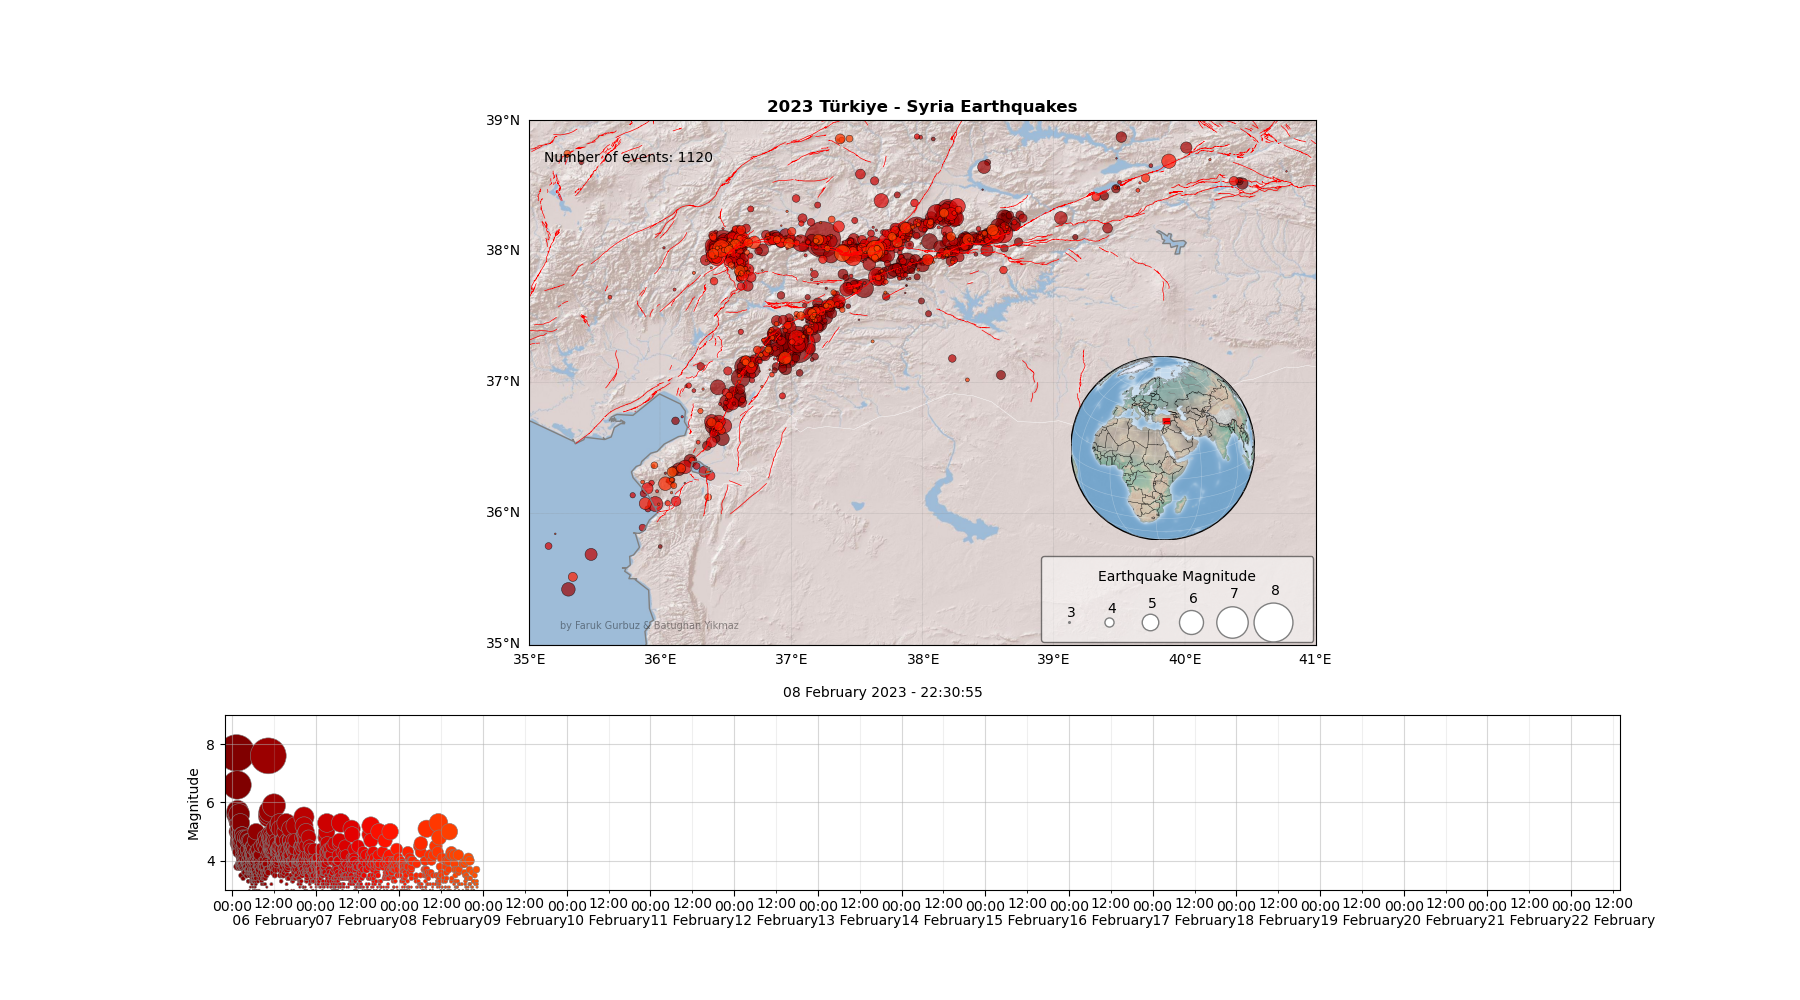

D:\Anaconda\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=35.0,35.0,41.0,39.0&bboxSR=4326&imageSR=4326&size=1500,1000&dpi=96&format=png32&transparent=true&f=image


FileNotFoundError: [WinError 2] Sistem belirtilen dosyayı bulamıyor

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(18, 10), height_ratios=[3, 1])
ax1, ax2 = axs
plot_top_fig(ax1)
plot_bottom_fig(ax2)

xx, yy = np.array(df.Longitude), np.array(df.Latitude)
position1 = list(zip(xx, yy))

xx, yy = np.array(df.index), np.array(df.Magnitude)
position2 = list(zip(xx, yy))

size = df.marker_size.to_list()
color = df.time_color.to_list()
count = np.arange(0, len(df)+1)
time = df.datetime_strf.to_list()


scat1 = ax1.scatter(position1[0][0], position1[0][1],
                  s=size[0], lw=0.4, edgecolors='k', facecolors=color[0], alpha=0.7)
count_text = ax1.text(0.02, 0.92, f'Number of events: 1', transform=ax1.transAxes)
scat2 = ax2.scatter(position2[0][0], position2[0][1],
                  s=size[0], lw=0.4, edgecolors='gray', facecolors=color[0])
time_text = ax2.text(0.4, 1.1, f'{time[0]}', transform=ax2.transAxes)

def animate1(i):
    i = i+1
    """perform animation step""" 
    scat1.set_offsets(position1[0:i])
    scat1.set_facecolors(color[0:i])
    scat1.set_sizes(size[0:i])
    count_text.set_text(f'Number of events: {count[i]}')
    return [scat1, count_text]

def animate2(i):
    i = i+1
    """perform animation step""" 
    scat2.set_offsets(position2[0:i])
    scat2.set_facecolors(color[0:i])
    scat2.set_sizes(size[0:i])
    time_text.set_text(f'{time[i]}')
    return [scat2, time_text]

def updateALL(frameNum):
    a = animate1(frameNum)
    b = animate2(frameNum)
    return b + a
    
ani = animation.FuncAnimation(fig, updateALL, frames=len(xx)-1,blit=True)
#ani.save('../results/earthquake_TR.mp4',writer=animation.FFMpegWriter(fps=25))
# ani.save('../results/earthquake_TR.gif', dpi=80, writer='imagemagick', fps=25) #not recommended
writergif = animation.PillowWriter(fps=50) 
ani.save("eartquake.gif", writer=writergif)
plt.show()

## animation (with depth)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3, 1])
ax1, ax2 = axs
plot_top_fig(ax1)
plot_bottom_fig2(ax2)

xx, yy = np.array(df.Longitude), np.array(df.Latitude)
position1 = list(zip(xx, yy))

xx, yy = np.array(df.index), np.array(df.Depth)
position2 = list(zip(xx, yy))

size = df.marker_size.to_list()
color = df.time_color.to_list()
count = np.arange(0, len(df)+1)
time = df.datetime_strf.to_list()


scat1 = ax1.scatter(position1[0][0], position1[0][1],
                  s=size[0], lw=0.4, edgecolors='k', facecolors=color[0], alpha=0.7)
count_text = ax1.text(0.02, 0.92, f'Number of events: 1', transform=ax1.transAxes)

scat2 = ax2.scatter(position2[0][0], position2[0][1],
                  s=size[0], lw=0.5, edgecolors='gray', facecolors=color[0])
time_text = ax2.text(0.4, 1.1, f'{time[0]}', transform=ax2.transAxes)

def animate1(i):
    i = i+1
    """perform animation step""" 
    scat1.set_offsets(position1[0:i])
    scat1.set_facecolors(color[0:i])
    scat1.set_sizes(size[0:i])
    count_text.set_text(f'Number of events: {count[i]}')
    return [scat1, count_text]

def animate2(i):
    i = i+1
    """perform animation step""" 
    scat2.set_offsets(position2[0:i])
    scat2.set_facecolors(color[0:i])
    scat2.set_sizes(size[0:i])
    time_text.set_text(f'{time[i]}')
    return [scat2, time_text]

def updateALL(frameNum):
    a = animate1(frameNum)
    b = animate2(frameNum)
    return b + a
    
ani = animation.FuncAnimation(fig, updateALL, frames=len(xx)-1,blit=True)
ani.save('../results/earthquake_TR_depth.mp4',writer=animation.FFMpegWriter(fps=25))
# ani.save('../results/earthquake_TR_depth.gif', dpi=80, writer='imagemagick', fps=25) #not recommended
plt.show()